In [1]:
import stim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# circuit
reps = 5
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=reps,
    distance=5,
    after_clifford_depolarization=0.002,
)

# create detection grid for circuit
det_coords = circuit.get_detector_coordinates()
det_coords = np.array(list(det_coords.values()))

# rescale space like coordinates:
det_coords[:, :2] = det_coords[:, :2] / 2

# convert to integers
det_coords = det_coords.astype(np.uint8)

# sampler
n_shots = 10
sampler = circuit.compile_detector_sampler()
stim_data, observable_flips = sampler.sample(shots=n_shots, separate_observables=True)

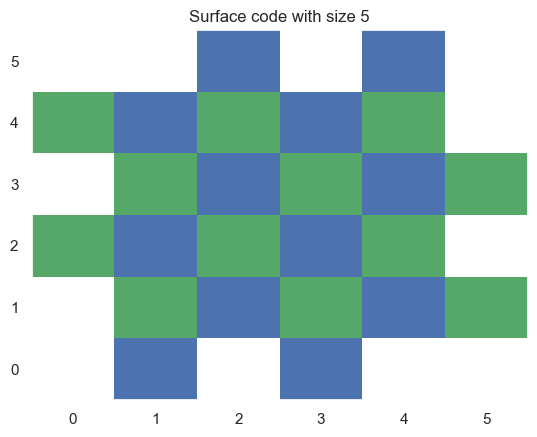

In [2]:
def syndrome_mask(code_size, reps=5):
    
    sz = code_size + 1
    
    syndrome_x = np.zeros((sz, sz), dtype=np.uint8)
    syndrome_x[::2, 1:sz - 1:2] = 1
    syndrome_x[1::2, 2::2] = 1
    
    syndrome_z = np.rot90(syndrome_x) * 3
    
    return np.dstack([syndrome_x + syndrome_z] * (reps +  1))

code_size = 5
m = syndrome_mask(code_size, reps)

fig, ax = plt.subplots()
xx, yy = np.meshgrid(range(6), range(6))

from matplotlib import colors as c

cmap = c.ListedColormap(['w', 'b', 'g'])
ax.pcolormesh(xx, yy, m[:, :, 0], cmap=cmap)
ax.set_title(f"Surface code with size {code_size}");


In [3]:
def stim_to_syndrome(stabilizer_changes, det_coords, code_grid):
    
    syndrome = np.zeros_like(code_grid)
    print(det_coords.shape)
    
    # stack stabilizer changes as first-to-last time step
    # note that detector coords represents the coordinates (x, y, t) of the measurement qubits
    syndrome[det_coords[:, 1], det_coords[:, 2], det_coords[:, 2]] = stabilizer_changes
    
    # we only care about differences in measurements
    syndrome[:, :, 1:] = (syndrome[:, :, 1:] - syndrome[:, :, 0:-1]) % 2
    
    # using our code_grid we can convert X/Z stabilizer measurements to 1:s and 3:s
    syndrome[np.nonzero(syndrome)] = code_grid[np.nonzero(syndrome)]
    
    return syndrome

In [4]:
# sums over the detectors to check if we have a parity change
shots_w_flips = np.sum(stim_data, axis=1) != 0

# save only data for measurements with non-empty syndromes
stabilizer_changes = stim_data[shots_w_flips, :]
flips = observable_flips[shots_w_flips]

print(f"{stabilizer_changes.shape=}")
print(f"{det_coords.shape=}")
print(f"{flips=}")

syndrome = stim_to_syndrome(stabilizer_changes[0, :], det_coords, m)


stabilizer_changes.shape=(6, 120)
det_coords.shape=(120, 3)
flips=array([[False],
       [False],
       [False],
       [False],
       [False],
       [False]])
(120, 3)
